<a href="https://colab.research.google.com/github/hamdansethi/NLP/blob/main/06_Linguistic_Feature_Engineering_for_Author_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

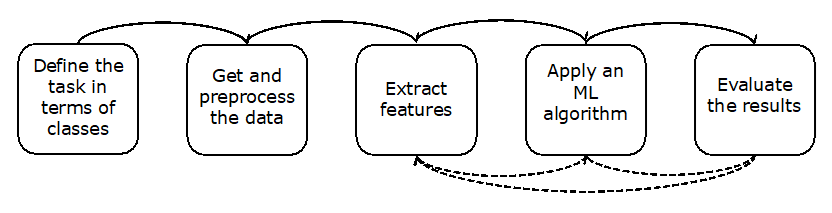

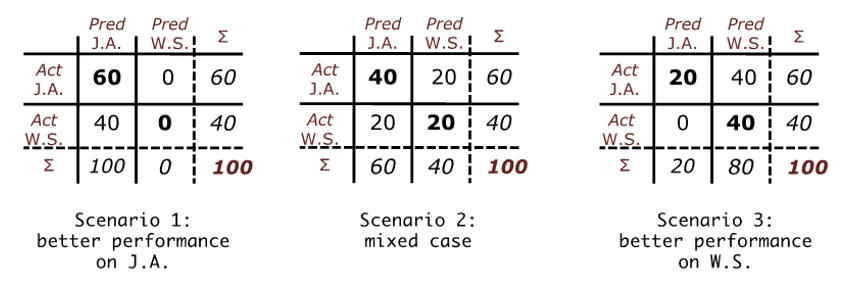

In [1]:
# Recall(class c) = number of instances of class c correctly identified as class c / total number of actual instances of class c in the set
# Precision(class c) = number of instances of class c correctly identified as class c / total number of instances the classifier identifies as class c
# F1 = 2*precision*recall / (precision + recall)

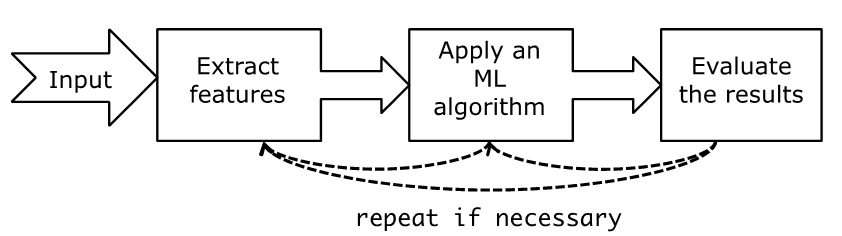

In [2]:
def avg_number_chars(text):
  total_chars = 0.0
  for word in text:
    total_chars += len(word)
  return float(total_chars)/float(len(text)) #A

def number_words(text):
  return float(len(text)) #B

print(avg_number_chars(["Not", "so", "happy", ",", "yet", "much", "happyer"]))
print(number_words(["Not", "so", "happy", ",", "yet", "much", "happyer"]))

#A Estimate average length of words in the sentence in terms of the number of characters
#B Calculate sentence length in terms of the number of words

3.5714285714285716
7.0


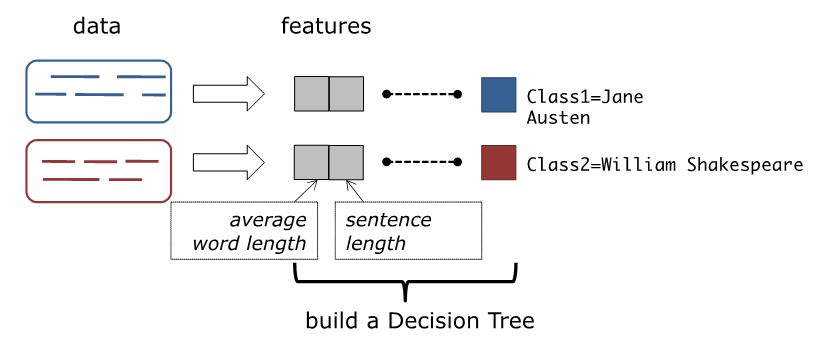

In [3]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg

gutenberg.fileids()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [4]:
nltk.download('punkt_tab')

author1_train = gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
author1_test = gutenberg.sents('austen-sense.txt')
author2_train = gutenberg.sents('shakespeare-caesar.txt') + gutenberg.sents('shakespeare-hamlet.txt')
author2_test = gutenberg.sents('shakespeare-macbeth.txt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
import random
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

all_sents = [(sent, "austen") for sent in author1_train]
all_sents += [(sent, "shakespeare") for sent in author2_train]
print (f"Dataset size = {str(len(all_sents))} sentences")
values = [author for (sent, author) in all_sents]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_train_set = []
strat_pretest_set = []

for train_index, pretest_index in split.split(all_sents, values):
  strat_train_set = [all_sents[index] for index in train_index]
  strat_pretest_set = [all_sents[index] for index in pretest_index]

Dataset size = 16768 sentences


In [6]:
test_set = [(sent, "austen") for sent in author1_test]
test_set += [(sent, "shakespeare") for sent in author2_test]

In [7]:
def initialize_dataset(source): #A
  all_features = []
  targets = []

  for (sent, label) in source: #B
    feature_list=[]
    feature_list.append(avg_number_chars(sent))
    feature_list.append(number_words(sent))
    all_features.append(feature_list) #C
    if label=="austen": targets.append(0)
    else: targets.append(1) #D
  return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set) #E

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets)) #F

#A Argument source denotes the dataset you are applying feature extraction to
#B Iterate through all (sent, label) pairs in the given dataset
#C Fill in feature vector feature_list with the features and add them to all_features
#D Append the relevant author label (0 or 1) to the list of targets
#E Apply this function to all datasets to initialize feature structures mapped with their labels (targets)
#F Print out the length of the structures

13414 13414
3354 3354
6906 6906


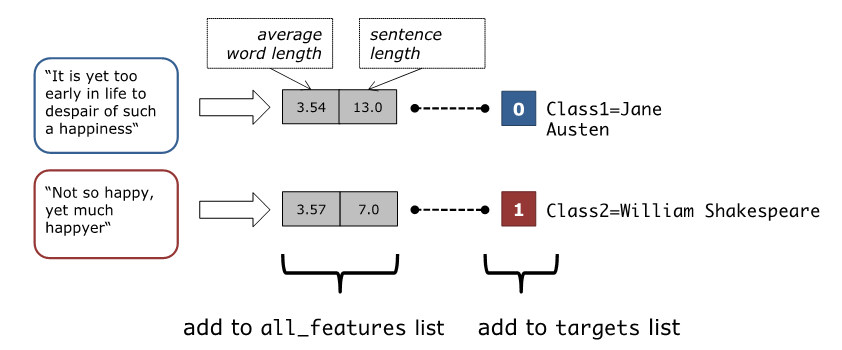

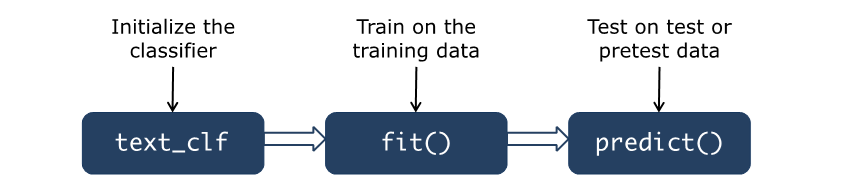

In [8]:
from sklearn.tree import DecisionTreeClassifier #A

text_clf = DecisionTreeClassifier(random_state=42) #B
text_clf.fit(train_data, train_targets) #C
predicted = text_clf.predict(pretest_data) #D

#A Upload the classifier from the sklearn’s suite of classifiers
#B Initialize the classifier and set the random state
#C Train the classifier using the fit method
#D Test the classifier using the predict method

In [9]:
import numpy as np
from sklearn import metrics #A

def evaluate(predicted, targets):
  print(np.mean(predicted == targets)) #B
  print(metrics.confusion_matrix(targets, predicted)) #C
  print(metrics.classification_report(targets, predicted)) #D

evaluate(predicted, pretest_targets)
predicted = text_clf.predict(test_data)
evaluate(predicted, test_targets) #E

#A Import numpy and sklearn’s metrics functionality
#B You can use numpy.mean to estimate the accuracy of the classifier
#C Use metrics.confusion_matrix to print out the confusion matrix for the class predictions
#D metrics.classification_report returns precision, recall and F1 values
#E Apply the same routine to the test set

0.7975551580202743
[[2133  167]
 [ 512  542]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2300
           1       0.76      0.51      0.61      1054

    accuracy                           0.80      3354
   macro avg       0.79      0.72      0.74      3354
weighted avg       0.79      0.80      0.78      3354

0.8049522154648132
[[4605  394]
 [ 953  954]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4999
           1       0.71      0.50      0.59      1907

    accuracy                           0.80      6906
   macro avg       0.77      0.71      0.73      6906
weighted avg       0.80      0.80      0.79      6906



In [10]:
# word_counts -> that counts the number of times each word occurs in text
# proportion_words -> which increments the count of a word from a particular wordlist each time you see it in text and estimates the proportion of the words from the wordlist against all other words in the end

def word_counts(text):
  counts = {}
  for word in text:
    counts[word.lower()] = counts.get(word.lower(), 0) + 1 #A
  return counts

def proportion_words(text, wordlist):
  count = 0
  for word in text:
    if word.lower() in wordlist:
      count += 1
  return float(count)/float(len(text)) #B

#A Each time you see a particular word in text, simply increment the counter
#B Estimate the proportion of the words from the wordlist against all other words

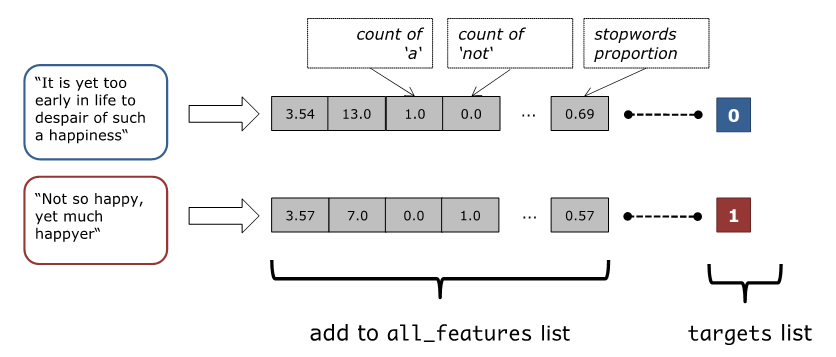

In [11]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm') #A

def initialize_dataset(source):
  all_features = []
  targets = []
  for (sent, label) in source:
    feature_list=[]
    feature_list.append(avg_number_chars(sent))
    feature_list.append(number_words(sent)) #B
    counts = word_counts(sent)
    for word in STOP_WORDS:
      if word in counts.keys():
        feature_list.append(counts.get(word))
      else:
        feature_list.append(0) #C
    feature_list.append(proportion_words(sent, STOP_WORDS)) #D
    all_features.append(feature_list)
    if label=="austen": targets.append(0)
    else: targets.append(1) #E
  return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set) #F

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets)) #G

#A Add spaCy’s functionality to the code and upload the stopwords list
#B Add the previous features to the set
#C For each stopword, either add the count to the feature list or add 0 if the stopword doesn’t occur in the sentence
#D Calculate the proportion of all stopwords combined as opposed to all words used in a sentence
#E As before, append the target labels
#F Initialize datasets with the new features
#G Print out the length of the feature lists and targets lists

13414 13414
3354 3354
6906 6906


In [12]:
nlp("How's your spicy its really spicy, don't you think?")

How's your spicy its really spicy, don't you think?

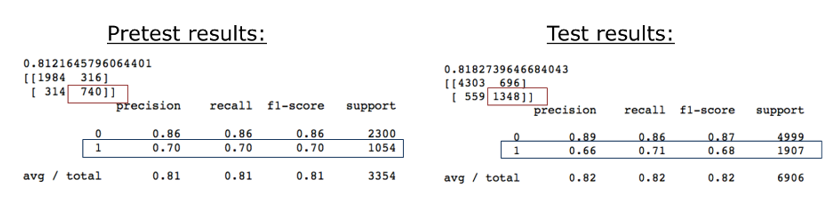

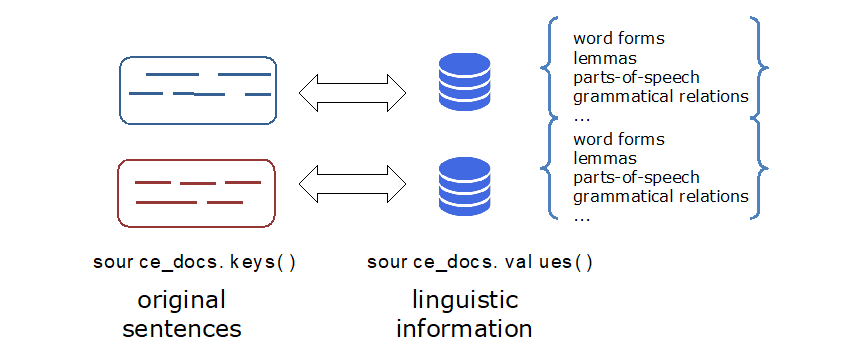

In [13]:
def preprocess(source): #A
  source_docs = {}
  index = 0
  for (sent, label) in source:
    text = " ".join(sent) #B
    source_docs[text] = nlp(text) #C

    if index>0 and (index%2000)==0:
      print(str(index) + " texts processed")
    index += 1

  print("Dataset processed") #D
  return source_docs

train_docs = preprocess(strat_train_set)
pretest_docs = preprocess(strat_pretest_set)
test_docs = preprocess(test_set) #E

#A Provide the preprocess function with the original sentences from the datasets
#B Merge the sentences back together using whitespaces
#C Add the processed linguistic information to the source_docs dictionary
#D Let’s add a printout message that notifies you every time another 2000 sentences have been processed
#E Apply the preprocess function to the three original datasets

2000 texts processed
4000 texts processed
6000 texts processed
8000 texts processed
10000 texts processed
12000 texts processed
Dataset processed
2000 texts processed
Dataset processed
2000 texts processed
4000 texts processed
6000 texts processed
Dataset processed


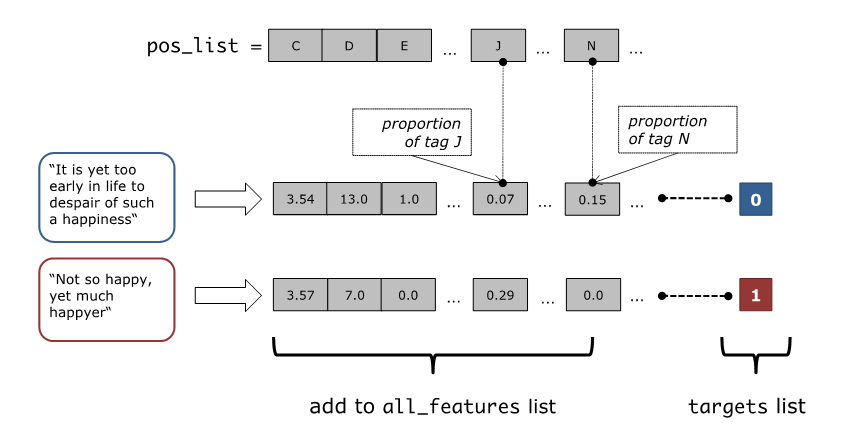

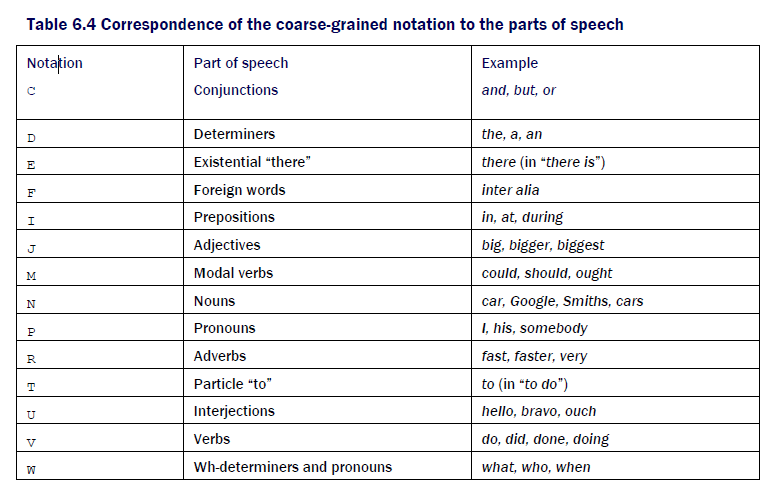

In [14]:
from collections import Counter #A

pos_list = ["C", "D", "E", "F", "I", "J", "M", "N", "P", "R", "T", "U", "V", "W"] #B

def pos_counts(text, source_docs, pos_list): #C

  pos_counts = {}
  doc = source_docs.get(" ".join(text))
  tags = []

  for word in doc:
    tags.append(str(word.tag_)[0]) #D
    counts = Counter(tags)

  for pos in pos_list:
    if pos in counts.keys():
      pos_counts[pos] = counts.get(pos)
    else: pos_counts[pos] = 0 #E

  return pos_counts

def initialize_dataset(source, source_docs):

  all_features = []
  targets = []

  for (sent, label) in source:

    feature_list=[]
    feature_list.append(avg_number_chars(sent))
    feature_list.append(number_words(sent))
    counts = word_counts(sent)

    for word in STOP_WORDS:
      if word in counts.keys():
        feature_list.append(counts.get(word))
      else:
        feature_list.append(0)

    feature_list.append(proportion_words(sent, STOP_WORDS)) #F
    p_counts = pos_counts(sent, source_docs, pos_list)

    for pos in p_counts.keys():
      feature_list.append(float(p_counts.get(pos))/float(len(sent))) #G

    all_features.append(feature_list)

    if label=="austen": targets.append(0)
    else: targets.append(1)

  return all_features, targets

#A Import Python’s Counter functionality to simplify counting procedures
#B Provide a coarse-grained list of part-of-speech tags that you’d like to extract
#C Extract part-of-speech tags from the linguistic containers and compare them to predefined tags
#D You only need the first letter from the actual part-of-speech tag
#E Populate pos_counts dictionary using the counts of the part-of-speech tags or inserting 0
#F Extract the previous 308 features as before
#G Add the new 14 features by calculating the proportion of words with each of the 14 part-of-speech tags

In [15]:
def run():
  train_data, train_targets = initialize_dataset(strat_train_set, train_docs)
  pretest_data, pretest_targets = initialize_dataset(strat_pretest_set, pretest_docs)
  test_data, test_targets = initialize_dataset(test_set, test_docs) #A

  print (len(train_data), len(train_targets))
  print (len(pretest_data), len(pretest_targets))
  print (len(test_data), len(test_targets)) #B
  print ()

  text_clf = DecisionTreeClassifier(random_state=42)
  text_clf.fit(train_data, train_targets) #C

  predicted = text_clf.predict(pretest_data)
  evaluate(predicted, pretest_targets) #D
  predicted = text_clf.predict(test_data)
  evaluate(predicted, test_targets) #E

run()

#A Initialize the datasets
#B As a sanity check, print out the sizes of the data sets
#C Train on the training set
#D Test and evaluate on the pretest set
#E Test and evaluate of the test set

13414 13414
3354 3354
6906 6906

0.821407274895647
[[1997  303]
 [ 296  758]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2300
           1       0.71      0.72      0.72      1054

    accuracy                           0.82      3354
   macro avg       0.79      0.79      0.79      3354
weighted avg       0.82      0.82      0.82      3354

0.832174920359108
[[4394  605]
 [ 554 1353]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4999
           1       0.69      0.71      0.70      1907

    accuracy                           0.83      6906
   macro avg       0.79      0.79      0.79      6906
weighted avg       0.83      0.83      0.83      6906



In [16]:
import operator #A

def select_suffixes(cutoff): #B
  all_suffixes = []
  for doc in train_docs.values(): #C
    for word in doc:
      all_suffixes.append(str(word.suffix_).lower()) #D

  counts = Counter(all_suffixes)
  sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True) #E

  selected_suffixes = []

  for i in range(0, round(len(counts)*cutoff)):
    selected_suffixes.append(sorted_counts[i][0]) #F
  return selected_suffixes

selected_suffixes = select_suffixes(0.4)
print(len(selected_suffixes))
print(selected_suffixes) #G

#A Import Python’s operator functionality, which is useful when sorting dictionaries
#B Implement a function to select a certain proportion of the most frequent suffixes in the data
#C Iterate through the list of values in the train_docs.values()
#D Suffixes can be directly accessed for each word in each sentence using word.suffix__
#E First, store the frequency of all the suffixes in the counts dictionary, and then sort it in descending order
#F Use some of the most frequent suffixes only; the suffixes can be accessed with sorted_counts[i][0]
#G Apply this function to extract and print out the most frequent 40% of the suffixes

577
[',', '.', 'the', 'and', 'to', 'ing', 'of', 'her', '"', 'a', 'i', 'hat', 'it', 'in', ';', 'was', 'not', 'she', 'you', 'his', 'uld', 'be', 'he', 'ere', 'had', "'", 'as', '--', 'all', 'ion', 'but', 'for', 'ith', 'ery', 'is', 'ave', 'ent', 'ill', 'nce', 'ght', 'ter', 'at', 'my', 'our', 'so', 'him', 'een', '?', 's', 'uch', 'ore', 'ome', 'mr', 'ver', 'are', 'ted', 'one', ':', 'ble', 'ell', 'no', 'on', 'now', 'any', 'ust', 'by', 'me', '!', 'hen', 'hey', 'out', 'ess', 'ich', '-', 'do', 'ure', 'mrs', 'ain', 'rom', 'elf', 'red', 'or', 'ood', 'if', 'mma', 'use', 'aid', 'hem', 'ton', 'ely', 'sed', 'own', 'est', 'man', 'an', 'ost', 'ake', 'ers', 'ear', 'nly', '_', 'we', 'iss', 'ned', 'ugh', '.--', 'lly', 'eir', 'ied', 'end', 'am', 'han', 'ons', 'did', 'ame', 'can', 'tle', 'ite', 'ose', 'ate', 'tly', 'how', 'ant', 'ard', 'ast', 'ong', 'ive', 'ity', 'who', 'ine', 'ved', 'eat', 'ect', 'iet', 'nne', 'ded', 'ink', 'way', 'ord', 'ous', 'ays', 'ime', 'ked', 'ady', 'say', 'age', 'ike', 'old', 'ies', '

In [17]:
def suffix_counts(text, source_docs, suffix_list): #A

  suffix_counts = {}
  doc = source_docs.get(" ".join(text))
  suffixes = []

  for word in doc:
    suffixes.append(str(word.suffix_))
  counts = Counter(suffixes)

  for suffix in suffix_list:
    if suffix in counts.keys():
      suffix_counts[suffix] = counts.get(suffix)
    else: suffix_counts[suffix] = 0

  return suffix_counts #B

def initialize_dataset(source, source_docs):
  all_features = []
  targets = []

  for (sent, label) in source:
    feature_list=[]
    feature_list.append(avg_number_chars(sent))
    feature_list.append(number_words(sent))
    counts = word_counts(sent)

    for word in STOP_WORDS:
      if word in counts.keys():
        feature_list.append(counts.get(word))
      else:
        feature_list.append(0)

    feature_list.append(proportion_words(sent, STOP_WORDS))
    p_counts = pos_counts(sent, source_docs, pos_list)

    for pos in p_counts.keys():
      feature_list.append(float(p_counts.get(pos))/float(len(sent))) #C

    s_counts = suffix_counts(sent, source_docs, selected_suffixes)
    for suffix in s_counts.keys():
      feature_list.append(float(s_counts.get(suffix))/float(len(sent))) #D

    all_features.append(feature_list)
    if label=="austen": targets.append(0)
    else: targets.append(1)
  return all_features, targets

run() #E


#A suffix_counts function returns the counts of suffixes from the suffix_list in the given sentence (text)
#B For each suffix from the suffix_list, use its count in the sentence if it occurs or 0 otherwise
#C Add the previous 322 features as before
#D Add the new 577 suffix distribution features by calculating the proportion of words containing the suffixes
#E Apply the train-test-evaluate routine as before

13414 13414
3354 3354
6906 6906

0.9564698867024448
[[2234   66]
 [  80  974]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2300
           1       0.94      0.92      0.93      1054

    accuracy                           0.96      3354
   macro avg       0.95      0.95      0.95      3354
weighted avg       0.96      0.96      0.96      3354

0.9481610194034173
[[4801  198]
 [ 160 1747]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4999
           1       0.90      0.92      0.91      1907

    accuracy                           0.95      6906
   macro avg       0.93      0.94      0.94      6906
weighted avg       0.95      0.95      0.95      6906



In [18]:
def unique_vocabulary(label1, label2, cutoff): #A
  voc1 = []
  voc2 = []

  for (sent, label) in strat_train_set:
    if label==label1:
      for word in sent:
        voc1.append(word.lower())
    elif label==label2:
      for word in sent:
        voc2.append(word.lower()) #B

  counts1 = Counter(voc1)
  sorted_counts1 = sorted(counts1.items(), key=operator.itemgetter(1), reverse=True)
  counts2 = Counter(voc2)
  sorted_counts2 = sorted(counts2.items(), key=operator.itemgetter(1), reverse=True) #C

  unique_voc = []

  for i in range(0, round(len(sorted_counts1)*cutoff)):
    if not sorted_counts1[i][0] in counts2.keys():
      unique_voc.append(sorted_counts1[i][0])
  for i in range(0, round(len(sorted_counts2)*cutoff)):
    if not sorted_counts2[i][0] in counts1.keys():
      unique_voc.append(sorted_counts2[i][0]) #D

  return unique_voc

unique_voc = unique_vocabulary("austen", "shakespeare", 0.5)
print(len(unique_voc))
print(unique_voc) #E

#A Implement a function that selects a certain proportion of the most frequent unique words for each author
#B First, collect full vocabularies – all words used – per each author
#C Next, count the number of times each word occurs with each author and sort them in descending order
#D The unique_voc list stores the most frequent words for each author if they are never used by the other author
#E Print out the unique_voc list using 50% as the cutoff

4435
['"', 'have', '--', '."', 'mr', 'mrs', 'emma', 'miss', 'than', '.--', ',"', 'only', 'every', 'never', 'harriet', 'anne', 'herself', 'own', 'weston', 'knightley', 'elton', 'again', 'always', 'soon', '!--', '?"', 'captain', 'jane', 'woodhouse', 'dear', 'elliot', 'ever', 'up', 'just', 'having', 'give', 'himself', 'fairfax', 'over', 'upon', 'seemed', 'wentworth', '!"', 'churchill', 'however', '?--', 'even', 'felt', 'really', 'frank', 'us', 'its', 'room', 'half', 'feelings', 'hartfield', 'certainly', 'charles', 'smith', 'bates', 'russell', 'believe', 'love', 'family', 'evening', 'feel', 'walter', ';--', 'hear', 'looked', 'idea', 'deal', 'acquaintance', 'myself', 'highbury', 'down', 'between', 'musgrove', 'mary', 'hour', 'subject', '`', 'louisa', 'perfectly', 'suppose', 'under', 'general', 'obliged', 'happiness', 'able', 'wanted', 'replied', 'given', 'john', 'talked', 'passed', 'elizabeth', '--"', 'understand', 'nobody', 'leave', 'kind', 'less', 'interest', 'near', 'attention', 'situati

In [19]:
def unique_counts(text, unique_voc): #A
  unique_counts = {}
  words = []

  for word in text:
    words.append(word.lower())
  counts = Counter(words)

  for word in unique_voc:
    if word in counts.keys():
      unique_counts[word] = counts.get(word)
    else: unique_counts[word] = 0 #B
  return unique_counts

def initialize_dataset(source, source_docs):
  all_features = []
  targets = []

  for (sent, label) in source:
    feature_list=[]
    feature_list.append(avg_number_chars(sent))
    feature_list.append(number_words(sent))
    counts = word_counts(sent)

    for word in STOP_WORDS:
      if word in counts.keys():
        feature_list.append(counts.get(word))
      else:
        feature_list.append(0)

    feature_list.append(proportion_words(sent, STOP_WORDS))
    p_counts = pos_counts(sent, source_docs, pos_list)

    for pos in p_counts.keys():
      feature_list.append(float(p_counts.get(pos))/float(len(sent)))
    s_counts = suffix_counts(sent, source_docs, selected_suffixes)

    for suffix in s_counts.keys():
      feature_list.append(float(s_counts.get(suffix))/float(len(sent))) #C
    u_counts = unique_counts(sent, unique_voc)

    for word in u_counts.keys():
      feature_list.append(u_counts.get(word)) #D
    all_features.append(feature_list)
    if label=="austen": targets.append(0)
    else: targets.append(1)
  return all_features, targets

run() #E

#A unique_counts function returns the counts of unique words from the unique_voc list in the given sentence
#B For each word from the unique_voc, use its count in the sentence if it occurs or 0 otherwise
#C Add the previous 899 features as before
#D Add the new 4,435 unique word counts features

13414 13414
3354 3354
6906 6906

0.9603458556946929
[[2233   67]
 [  66  988]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2300
           1       0.94      0.94      0.94      1054

    accuracy                           0.96      3354
   macro avg       0.95      0.95      0.95      3354
weighted avg       0.96      0.96      0.96      3354

0.9606139588763394
[[4855  144]
 [ 128 1779]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4999
           1       0.93      0.93      0.93      1907

    accuracy                           0.96      6906
   macro avg       0.95      0.95      0.95      6906
weighted avg       0.96      0.96      0.96      6906

